# Онлайн алгоритмы в задаче формирования портфеля ценных бумаг

## Постановка задачи

В задаче формирования портфеля ценных бумаг допустимыми решениями являются всевозможные распределения состояния, имеющегося у игрока, т.е. элементы стандартного симплекса:

$$
\Delta_d = \left\{
x \in \mathbb{R}^d
:\;
\sum_{i = 1}^d x_i = 1,
\;
x_i \geq 0
\right\}.
$$

Противник (природа) независимо выбирает рыночную доходность активов,
т.е. вектор $r_t \in \mathbb{R}_+^d$,
у которого $i$-ая компонента определяется формулой

$$
[r_t]_i = \frac{\text{цена единицы $i$-го актива в момент } t + 1}{\text{цена единицы $i$-го актива в момент } t}.
$$

*Цель игрока* — максимизировать свое состояние по проишествии $T$ раундов, которая эквивалентна максимизации величины

$$
\sum_{t=1}^T \log r_t^\top x_t,
$$

которую будем называть *логарифмическим приростом* портфеля ценных бумаг к моменту времени $T$.

Регрет алгоритма $\mathcal{A}$ к раунду $T$ определяется формулой

$$
\mathrm{regret}_T(\mathcal{A})
=
\sum_{t=1}^T f_t(x_t)
-
\min_{x \in \Delta_d}
\sum_{t = 1}^T f_t(x),
$$

где $f_t(x) = -\log r_t^\top x$.

В этом задании вам предстоит реализовать алгоритмического инвестора на основе онлайн градиентного спуска, принимающего решения о перераспределении имеющихся средств между акциями российского фондового рынка:
- в момент времени $t$ алгоритм должен предложить распределение средств между активами $x_t$;
- после этого алгоритму открывается вектор рыночных доходностей $r_t$ из истории наблюдений;
- алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации.

## Подготовка данных (3 балла)

Загрузите котировки (сформируйте набор данных) акций `RASP`, `GAZP`, `DSKY`, `SBER`, `KMAZ`, `RUAL` c 01.04.2020 по 22.04.2022 с интервалом в один день (раунд игры = день). Выведите таблицу (`pd.DataFrame`), в которой столбцы содержат временные ряды для каждого тикера, а их названия — тикеры. **[1 балл]**

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from numpy.typing import ArrayLike
from typing import List, Tuple
from scipy.special import expit

In [2]:
# загрузка и подготовка данных
tickers = ['RASP.ME', 'GAZP.ME', 'DSKY.ME', 'SBER.ME', 'KMAZ.ME', 'RUAL.ME']

start_date = '2020-04-01'
end_date = '2022-04-22'

data = yf.download(tickers, start=start_date, end=end_date)['Close']

data

[*********************100%***********************]  6 of 6 completed


,DSKY.ME,GAZP.ME,KMAZ.ME,RASP.ME,RUAL.ME,SBER.ME
Date,,,,,,
2020-04-01,90.120003,180.059998,51.000000,97.760002,24.754999,184.779999
2020-04-02,90.620003,187.039993,50.599998,99.400002,24.955000,186.949997
2020-04-03,94.419998,189.770004,53.599998,99.099998,24.830000,185.639999
2020-04-06,97.800003,191.100006,54.400002,100.919998,25.754999,190.699997
2020-04-07,98.120003,191.220001,54.599998,98.980003,26.049999,197.630005
...,...,...,...,...,...,...
2022-04-15,77.720001,224.000000,100.099998,398.600006,66.750000,130.880005
2022-04-18,75.599998,216.990005,100.099998,403.149994,64.605003,123.849998
2022-04-19,75.199997,220.720001,99.300003,391.149994,63.200001,120.300003


Визуализируйте поведение всех тикеров на всём горизонте игры. **[1 балл]**

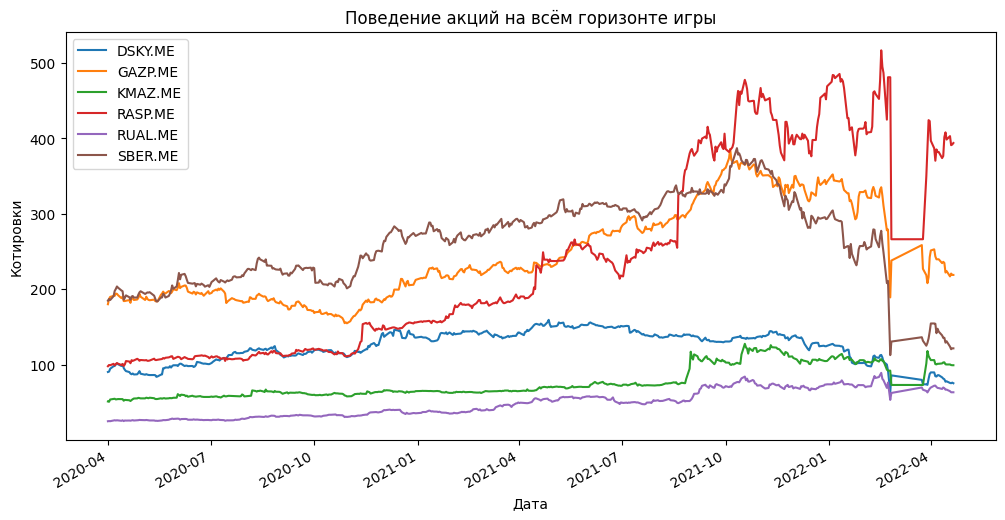

In [3]:
# красивая визуализация на графике с подписями и адекватным масштабом

data.plot(figsize=(12,6))

plt.title('Поведение акций на всём горизонте игры')
plt.xlabel('Дата')
plt.ylabel('Котировки')

plt.show()

Постройте таблицу (с тем же заголовком), содержащую по столбцам временные ряды *рыночных доходностей* тикеров. **[1 балл]**


In [4]:
table = []
for t in range(1, len(data.values)):
    x = data.values[t]/data.values[t-1]
    table.append(x)

returns = pd.DataFrame(index = data.index[1:], columns = data.columns, data = table)
# Строим таблицу с ежедневными доходностями каждого тикера
returns

,DSKY.ME,GAZP.ME,KMAZ.ME,RASP.ME,RUAL.ME,SBER.ME
Date,,,,,,
2020-04-02,1.005548,1.038765,0.992157,1.016776,1.008079,1.011744
2020-04-03,1.041933,1.014596,1.059289,0.996982,0.994991,0.992993
2020-04-06,1.035798,1.007008,1.014925,1.018365,1.037253,1.027257
2020-04-07,1.003272,1.000628,1.003676,0.980777,1.011454,1.036340
2020-04-08,1.019160,1.015113,0.983517,1.017175,0.988484,1.013459
...,...,...,...,...,...,...
2022-04-15,1.006214,1.008509,0.998006,0.976602,1.001500,1.014181
2022-04-18,0.972723,0.968705,1.000000,1.011415,0.967865,0.946287
2022-04-19,0.994709,1.017190,0.992008,0.970234,0.978252,0.971336


## Онлайн градиентный спуск (8 баллов)

Приведите выражение для градиента функции $f_t(x)$ и запишите явную формулу для итерации OGD. **[1 балл]**

*Место для выкладок.*

Реализуйте инвестора, принимающего решение на основе итераций онлайн градиентного спуска. **[4 балла]**

Используйте готовую функцию `simplex_projection`, проектирующую входной вектор на стандартный симплекс.

In [ ]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [ ]:
# реализация онлайн градиентного спуска

### Запуск OGD

Как будете выбирать шаг при запуске OGD? Приведите исчерпывающее объяснение и мотивацию. **[1 балл]**

*Место для выкладок.*

Начиная с равномерного распределения состояния между активами, запустите OGD на всём горизонте игры. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, зафиксировавшего своё (произвольное) распределение в начале игры. **[2 балла]**

In [ ]:
# красивая визуализация на графике с подписями и адекватным масштабом

## Дополнительное задание (4 балла)

Реализуйте любой подходящий канонический онлайн алгоритм из курса или даже их композицию. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, принимающего решения на основе выбранного алгоритма. Сравните итоговые распределения, полученные с помощью этих алгоритмов, и попробуйте сделать выводы.

In [ ]:
# место для кода